TODO: inference here is wrong because I need to .sample_survivors with rho before making any model that specifies rho... see gcdyn/notebooks/discrete_mutator.ipynb

# Assessing birth-death-mutation model MLE convergence

In [6]:
import itertools
import jax.numpy as np
import matplotlib.pyplot as plt
import pickle
from gcdyn import bdms
from gcdyn.model import Model
from jax import jit, grad
from tqdm.auto import tqdm
from collections import namedtuple
from ete3.coretype.tree import TreeError

def plot_curve(*θ_values, range = (-10, 10), **named_θ_values):
    x_array = np.linspace(*range)
    λ = lambda θ: Model.λ(None, x_array, θ)

    plt.figure()

    for θ in θ_values:
        plt.plot(x_array, λ(θ), color = "black", alpha = 0.5)

    for name, θ in named_θ_values.items():
        plt.plot(x_array, λ(θ), label = name)
    
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\lambda_\theta(x)$")
    plt.xlim(*range)
    
    if named_θ_values:
        plt.legend()

    plt.show()


def evolve_trees(num_trees, **evolve_kwargs):
    trees = []
    seed = evolve_kwargs.pop("seed", None)

    for _ in range(num_trees):
        while True:
            try:
                tree = bdms.TreeNode()
                tree.evolve(seed = seed, **evolve_kwargs)
                trees.append(tree)
                break

            except TreeError: # not enough survivors
                seed = seed + 1 if seed is not None else None

        seed = seed + 1 if seed is not None else None

    summarize_trees(trees)

    return trees


def summarize_trees(trees):
    print("Average of", sum(len(list(tree.traverse())) for tree in trees) / len(trees), "nodes per tree, over", len(trees), "trees")


def prune_trees(trees, ρ, seed = None):
    copied_trees = [tree.copy() for tree in trees]

    for tree in copied_trees:
        # if statement is for not having an error if you call it twice accidentally
        if not tree._sampled:
            tree.sample_survivors(p = ρ, seed = seed)
            tree.prune()

    return copied_trees


## Demo usage of gcdyn module

### Example 1

In [3]:
θ = [2, 1, 0, 0]
num_trees = 2

Average of 319.5 nodes per tree, over 2 trees
Solution in 9 iterations: [ 1.8065567  1.7891619 -0.3597566  0.       ]


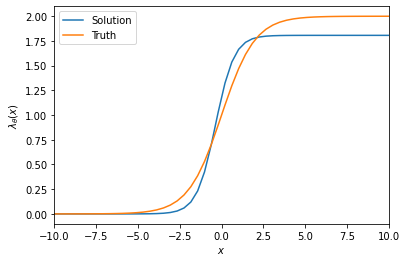

In [7]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit()
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ)

### Example 2

We now try a reverse sigmoid, which is not necessarily biologically motivated (since we expect birth rate to increase with fitness) but statistically as relevant as the previous example.
Note that to reverse the sigmoid, we want to invert `θ[1]`.
In optimization, we also need to relax the constraint on `θ[1]`.

In [4]:
θ = [2, -1, 0, 0]
num_trees = 2

Average of 710.0 nodes per tree, over 2 trees
Solution in 9 iterations: [ 2.0493498  -0.5627433  -0.3167873   0.00596557]


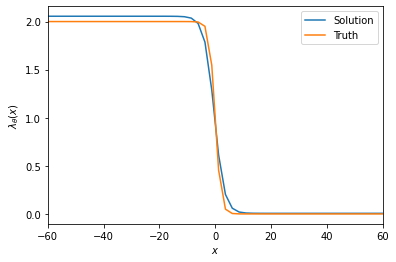

In [5]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

Note that when growing trees, child phenotypes are generated to be smaller than their parent's phenotypes, on average.
This encourages children to have lower birth rates, on average.
But, by reversing the sigmoid, we are actually now encouraging higher birth rates, which is leading to very large trees.
Let's try changing the phenotype shift to be positive (which is toward lower birth rates in this model).

Notice how the JIT compile time drops as the sizes of the trees drops... (or is it just my choice of seed?)

Average of 536.5 nodes per tree, over 2 trees
Solution in 15 iterations: [ 2.087087   -1.1152506   0.46359396  0.        ]


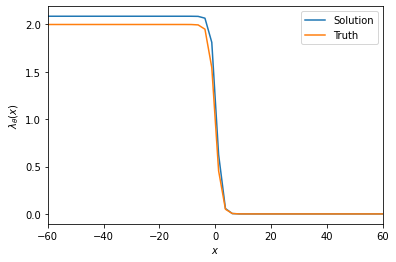

In [6]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 2
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

## Code to try different initial values for MLE runs

Note that this still assumes a single model with a fixed $θ$; we just try to run the algorithm from different starting points.

In [7]:
def try_init_values(model, true_θ, *search_ranges, print_skipped_values = False):
    """
    Runs MLE algorithm for `model` starting from points in the specified range of initial values,
    and plots the resulting log likelihoods against the distance of the initial value from the true parameter value.
    """

    true_θ = np.array(true_θ)

    search_space = itertools.product(*search_ranges)
    search_space = [np.array(t, dtype = float) for t in search_space]

    magnitudes = []
    log_liks = []
    skipped_values = []

    Result = namedtuple("Result", ("θ_init", "θ_result", "magnitude", "log_lik"))
    Result.__repr__ = lambda self: f"θ_init: {self.θ_init}, magnitude: {self.magnitude}, log lik: {self.log_lik}, θ_result: {self.θ_result}"
    results = []

    for θ_init in tqdm(search_space, desc = "Init value #"):
        result = model.fit(init_value = θ_init)
        log_lik = result.state.fun_val

        if np.isnan(log_lik):
            skipped_values.append(θ_init)

        else:
            results.append(Result(
                θ_init    = θ_init,
                θ_result  = result.params,
                magnitude = np.sqrt(np.power(true_θ - θ_init, 2).sum()),
                log_lik   = log_lik
            ))

    magnitudes = np.array([result.magnitude for result in results])
    log_liks = np.array([result.log_lik for result in results])

    plt.scatter(magnitudes, log_liks)
    plt.xlabel(r"$||\theta - \theta\_init||$")
    plt.ylabel("log likelihood of result")
    plt.show()

    if skipped_values:
        print(f"Note: {len(skipped_values)}/{len(search_space)} initial values were skipped.")

        if print_skipped_values:
            for val in skipped_values:
                print(val)
        
        else:
            print("Pass argument `print_skipped_values = True` to see them.")

    return results

Average of 302.0 nodes per tree, over 1 trees


Init value #:   0%|          | 0/1250 [00:00<?, ?it/s]

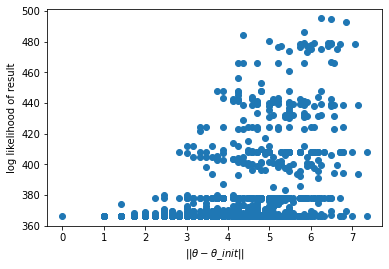

Note: 50/1250 initial values were skipped.
Pass argument `print_skipped_values = True` to see them.


In [8]:
θ = [2, 1, 0, 0]
num_trees = 1

trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

results = try_init_values(model, θ, range(0, 5), range(0, 5), range(-5, 5), range(0, 5))

## MLE on BEAST trees

Average of 55.666666666666664 nodes per tree, over 21 trees
Solution in 6 iterations: [2.0692263  1.2352401  2.377035   0.01314545]


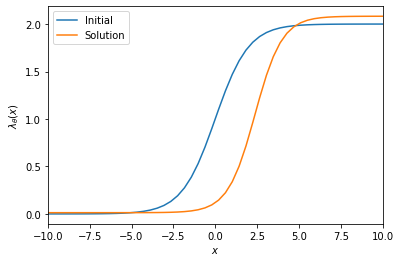

In [9]:
with open("tenseqs_subset-ete3_trees.pickle", "rb") as trees_file:
    beast_trees = pickle.load(trees_file)

some_trees = list(beast_trees.values())[80:]
summarize_trees(some_trees)

model = Model(some_trees, μ = 1, γ = 1, ρ = 0.5)

θ_init = [2, 1, 0, 0]
mle = model.fit(init_value = θ_init)
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Initial = θ_init, Solution = mle.params)

## What if we prune the trees?

In reality, we don't observe dead lineages, so we need to prune the trees to see how well inference would go on data we would observe.
Here, we randomly sample half the leaves.

### Example 1

Pruning is a random procedure, so we can run independent/parallel prunes and observe the different results we obtain, like a confidence band of sorts

Average of 220.1 nodes per tree, over 10 trees


2022-10-10 13:27:04.752340: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 7m49.797326s

********************************
[Compiling module jit__lambda_.0] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Truth: [2, 1, 0, 0]
Solution in 13 iterations: [ 2.1534045  1.1465403 -0.182875   0.       ]
Solution in 43 iterations after pruning: [ 0.45439756 42.834805    1.2897148   0.49392402]
Solution in 40 iterations after pruning (individual): [ 0.67010665 54.603214    0.91189903  0.2397865 ]
Solution in 42 iterations after pruning (individual): [0.33577847 9.752874   0.80786973 0.5659153 ]
Solution in 10 iterations after pruning (individual): [1.1674446  0.1801611  0.34549284 0.        ]
Solution in 54 iterations after pruning (individual): [  0.5768762  -24.673649     0.6357689    0.40797734]
Solution in 59 iterations after pruning (individual): [100.22295     54.21978      2.420627     0.40057534]
Solution in 14 iterations after pruning (individual): [0.9276186 0.4139208 1.6531091 0.       ]
Solution in 35 iterations after pruning (individual): [ 1.1074106 24.414352   1.492541   0.2346419]
Solution in 21 iterations after pruning (individual): [2.1112914  6.331947   1.4650003  0.40828294]


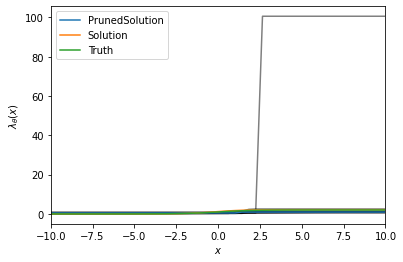

In [2]:
θ = [2, 1, 0, 0]
num_trees = 10

trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Truth: {θ}")
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")

pruned_trees = prune_trees(trees, ρ = 0.5, seed = 0)

model = Model(pruned_trees, μ = 1, γ = 1, ρ = 0.5)
pruned_mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Solution in {pruned_mle.state.iter_num} iterations after pruning: {pruned_mle.params}")

individual_pruned_mles = []

for tree in pruned_trees:
    # Because of JIT, you need to build a new model with the modified trees
    model = Model([tree], μ = 1, γ = 1, ρ = 0.5)

    individual_mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
    print(f"Solution in {individual_mle.state.iter_num} iterations after pruning (individual): {individual_mle.params}")

    individual_pruned_mles.append(individual_mle)

plot_curve(*[mle.params for mle in individual_pruned_mles], PrunedSolution = pruned_mle.params, Solution = mle.params, Truth = θ)

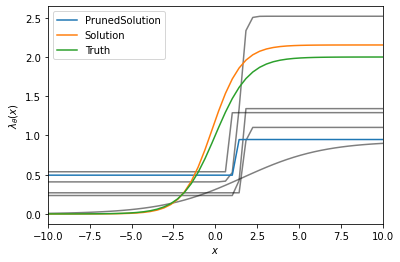

In [3]:
plot_curve(*[mle.params for mle in individual_pruned_mles][5:], PrunedSolution = pruned_mle.params, Solution = mle.params, Truth = θ)

### Example 2

Average of 288.6 nodes per tree, over 10 trees


2022-10-10 13:03:00.297649: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_.45] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-10-10 13:03:02.868638: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m2.575724s

********************************
[Compiling module jit__lambda_.45] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Truth: [2, -1, 0, 0]
Solution in 12 iterations: [ 2.0504858 -1.1867632  0.3086121  0.       ]
Solution in 21 iterations after pruning: [ 0.85824776 -1.3790201  -0.11526603  0.        ]
Solution in 12 iterations after pruning (individual): [ 1.6782503  -1.7148597  -1.2535509   0.08876783]
Solution in 54 iterations after pruning (individual): [ 0.41121796 25.25399    -0.8182995   0.411476  ]
Solution in 49 iterations after pruning (individual): [  0.36170337 -51.28459     -1.0408034    0.23876952]
Solution in 17 iterations after pruning (individual): [ 1.1669399  -0.68811625 -0.87297034  0.        ]
Solution in 11 iterations after pruning (individual): [ 1.1814232 -0.0594699 -0.5038281  0.       ]
Solution in 42 iterations after pruning (individual): [  0.99852103 -58.001568    -0.94533604   0.26582852]
Solution in 46 iterations after pruning (individual): [  0.50167924 -27.47683     -1.1233612    0.32125333]
Solution in 9 iterations after pruning (individual): [ 1.4306047   0.5050043  -

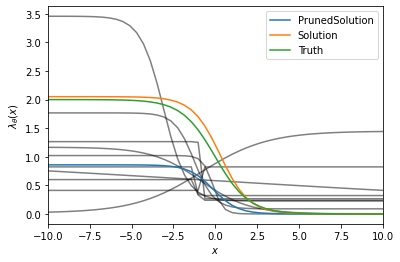

In [14]:
θ = [2, -1, 0, 0]
num_trees = 10

trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Truth: {θ}")
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")

pruned_trees = prune_trees(trees, ρ = 0.5, seed = 0)

model = Model(pruned_trees, μ = 1, γ = 1, ρ = 0.5)
pruned_mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Solution in {pruned_mle.state.iter_num} iterations after pruning: {pruned_mle.params}")

individual_pruned_mles = []

for tree in pruned_trees:
    # Because of JIT, you need to build a new model with the modified trees
    model = Model([tree], μ = 1, γ = 1, ρ = 0.5)

    individual_mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
    print(f"Solution in {individual_mle.state.iter_num} iterations after pruning (individual): {individual_mle.params}")

    individual_pruned_mles.append(individual_mle)

plot_curve(*[mle.params for mle in individual_pruned_mles], PrunedSolution = pruned_mle.params, Solution = mle.params, Truth = θ)